In [11]:
# Library
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import sklearn
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgbm
from lightgbm import plot_importance, LGBMRegressor, early_stopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold

import warnings
warnings.filterwarnings('ignore')


In [3]:
# Fix Seed 
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [4]:
# Load Data
train_df = pd.read_csv('./open/train.csv')
train_x = train_df.filter(regex="X")
train_y = train_df.filter(regex="Y")

test = pd.read_csv("./open/test.csv").drop(columns='ID')

In [24]:
# LGBM 주요 변수 : X 03,05,07,08,09 49~56

train_x = train_x[['X_03', 'X_05', 'X_07', 'X_08', 'X_09',
                   'X_49', 'X_50', 'X_51', 'X_52', 'X_53',
                   'X_54', 'X_55', 'X_56']]

In [8]:
# 중요 타겟 변수로 축소 Y_04, Y_05, Y_06
train_y = train_y['Y_04']

In [9]:
# Del useless feature("X_04", "X_23", "X_47", "X_48")
X_tr_std = pd.Series(np.std(train_x))
Del_idx = X_tr_std[X_tr_std==0].index

train_x = train_x.drop(columns=Del_idx)
test = test.drop(columns=Del_idx)

train_x.shape, test.shape

((39607, 52), (39608, 52))

In [10]:
# Data Split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2)

X_train.shape, X_val.shape

((31685, 52), (7922, 52))

In [7]:
# 평가 산식(NRMSE)
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,14): # ignore 'ID'
        rmse = mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score

In [25]:
# Modeling
lgb = LGBMRegressor()

kfold = KFold(n_splits=5)
num_iter = 0

cv_rmse = []

print(train_x.shape, train_y.shape)

# 5 Cross validation 
for train_idx, val_idx in kfold.split(train_x):
    X_tr, X_val = train_x.iloc[train_idx, :], train_x.iloc[val_idx, :]
    y_tr, y_val = train_y.iloc[train_idx], train_y.iloc[val_idx]
    lgb.fit(X_tr, y_tr, verbose=True)
    
    y_pred = lgb.predict(X_val)
    num_iter = num_iter + 1
    rmse = round(mean_squared_error(y_val, y_pred, squared=False), 4)
    
    print('Validation set{}, RMSE : {}'.format(num_iter, rmse))
    cv_rmse.append(rmse)
print("mean of rmse : {}".format(round(np.mean(cv_rmse),4)))

(39607, 13) (39607,)
Validation set1, RMSE : 2.6222
Validation set2, RMSE : 2.5226
Validation set3, RMSE : 2.5945
Validation set4, RMSE : 2.8556
Validation set5, RMSE : 2.5621
mean of rmse : 2.6314


In [75]:
# Iterative Single Prediction
rmse_list = []

lgb = LGBMRegressor()
for i in range(y_train.shape[1]):
    evals=[(X_val, y_val.iloc[:,i])]
    lgb.fit(X_train, y_train.iloc[:,i], early_stopping_rounds=100, eval_metric='rmse', eval_set=evals, verbose=True)
    val_pred = lgb.predict(X_val)
    rmse = mean_squared_error(y_val.iloc[:,i], val_pred, squared=False)
    print(rmse)
    rmse_list.append(rmse)
print('Done.')

[1]	valid_0's rmse: 0.353879	valid_0's l2: 0.12523
[2]	valid_0's rmse: 0.352809	valid_0's l2: 0.124474
[3]	valid_0's rmse: 0.351982	valid_0's l2: 0.123892
[4]	valid_0's rmse: 0.351179	valid_0's l2: 0.123327
[5]	valid_0's rmse: 0.350552	valid_0's l2: 0.122887
[6]	valid_0's rmse: 0.349969	valid_0's l2: 0.122478
[7]	valid_0's rmse: 0.349529	valid_0's l2: 0.122171
[8]	valid_0's rmse: 0.349058	valid_0's l2: 0.121842
[9]	valid_0's rmse: 0.348658	valid_0's l2: 0.121563
[10]	valid_0's rmse: 0.348267	valid_0's l2: 0.12129
[11]	valid_0's rmse: 0.347914	valid_0's l2: 0.121044
[12]	valid_0's rmse: 0.347611	valid_0's l2: 0.120834
[13]	valid_0's rmse: 0.34731	valid_0's l2: 0.120624
[14]	valid_0's rmse: 0.347144	valid_0's l2: 0.120509
[15]	valid_0's rmse: 0.346919	valid_0's l2: 0.120353
[16]	valid_0's rmse: 0.346818	valid_0's l2: 0.120283
[17]	valid_0's rmse: 0.346772	valid_0's l2: 0.120251
[18]	valid_0's rmse: 0.346661	valid_0's l2: 0.120174
[19]	valid_0's rmse: 0.346536	valid_0's l2: 0.120087
[20]	

In [76]:
rmse_list

[0.34570159614264157,
 0.37625777210582595,
 0.35300931477428926,
 2.5390963104819244,
 2.4637267943559196,
 1.6563502475155474,
 0.4051928986199783,
 0.6260678897826941,
 0.6214908241183745,
 0.8429854271356673,
 0.7994061809039865,
 0.6219478980003271,
 0.6207185479490317,
 0.6209809746928796]

In [45]:
lg_nrmse(np.array(y_val), val_pred)

1.9421685299979659

In [47]:
preds = lgb.predict(test)
print('Done.')

Done.


In [48]:
submit = pd.read_csv('./open/sample_submission.csv')

for id, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = preds[:,id-1]
print('Done.')

Done.


In [49]:
submit.to_csv('./submit.csv',index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

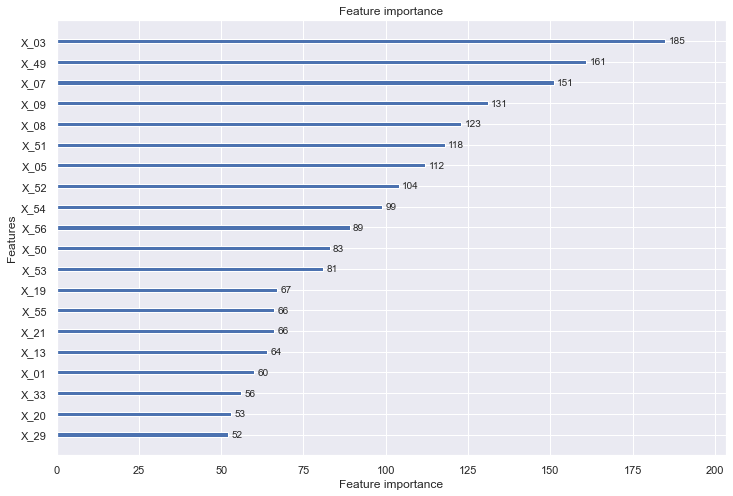

In [23]:
f, ax = plt.subplots(figsize=(12,8))
plot_importance(lgb, max_num_features=20, ax=ax)

In [41]:
from xgboost import XGBRegressor

xgb = MultiOutputRegressor(XGBRegressor()).fit(X_train, y_train)
preds = xgb.predict(X_val)

preds.shape

(7922, 14)

In [42]:
lg_nrmse(np.array(y_val), preds)

1.993579837618271

In [43]:
# modeling

lasso = MultiOutputRegressor(Lasso()).fit(X_train, y_train)
preds = lasso.predict(X_val)

preds.shape

lg_nrmse(np.array(y_val), preds)

2.0013296946606958